# Target

The links below show the quick look lightcurve reduced using a K2 data pipeline called [K2SFF](https://archive.stsci.edu/prepds/k2sff/) available online.

* 	[EPIC212099230](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=212099230)

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

# K2-C5/C16 lightcurve using everest-pipeline

* [paper](https://arxiv.org/abs/1607.00524)
* [code](https://github.com/rodluger/everest)
* [doc](http://staff.washington.edu/rodluger/everest/using_everest.html)

In [3]:
import everest
everest.__version__

'2.0.9'

## Downloading data

In [4]:
epic = everest.Everest(212099230)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 212099230.


In [5]:
epic.time

array([2306.61051638, 2306.63094854, 2306.65138049, ..., 2381.39074896,
       2381.41118099, 2381.43161292])

The timeseries is stored in `star.time` and `star.flux` (PLD-de-trended flux) or `star.fcor` (de-trended flux with CBV correction). The indices of all outliers are stored in `star.mask`.

* pixel level decorrelation (PLD)
* co-trending basis vector (CVB)

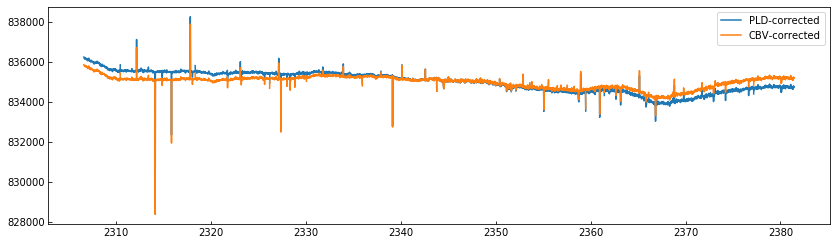

In [6]:
%matplotlib inline
import matplotlib.pyplot as pl

fig = pl.figure(figsize=(14,4))

pl.plot(epic.time,epic.flux,label='PLD-corrected')
pl.plot(epic.time,epic.fcor,label='CBV-corrected')
pl.legend()

INFO  [everest.user.plot()]: Plotting the light curve...


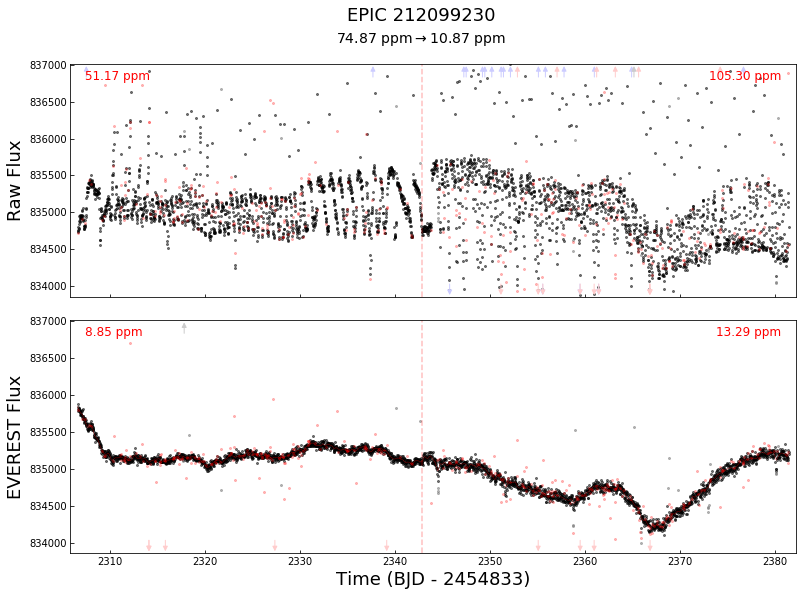

In [7]:
epic.plot()

## aperture

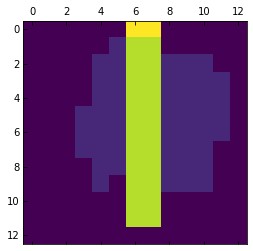

In [8]:
pl.matshow(epic.aperture)

INFO  [everest.basecamp.plot_aperture()]: Plotting the aperture...


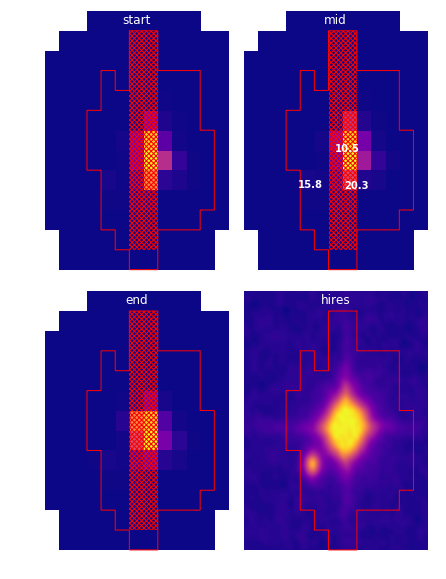

In [9]:
epic.plot_aperture()

## convert into dataframe

In [10]:
import pandas as pd

#convert to df
t = epic.time
f = epic.flux
df = pd.DataFrame(f, 
                  columns=['flux'], 
                  index=t)
                  #, name=epic.ID)
df = df.reset_index()
df.columns = ['t','f']
df.head()

,t,f
0,2306.610516,836247.099976
1,2306.630949,836218.930036
2,2306.651380,836190.036020
3,2306.671813,836171.966265
4,2306.692245,836157.919368


## De-trended lightcurve using everest-pipeline

In [12]:
#styling
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

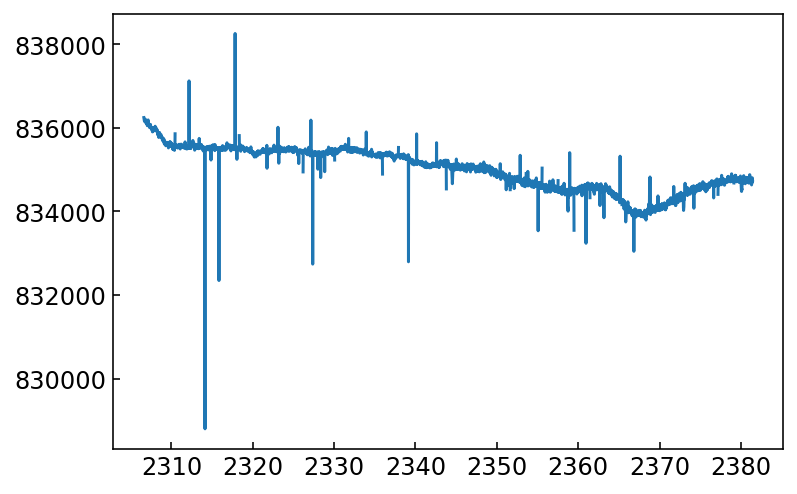

In [13]:
import matplotlib.pyplot as pl

%matplotlib inline

pl.plot(t,f,'-')

## removing outliers

In [14]:
def apply_mask(self, x=None):
    '''
    Returns the outlier mask, an array of indices corresponding to the
    non-outliers.

    :param numpy.ndarray x: If specified, returns the masked version of \
           :py:obj:`x` instead. Default :py:obj:`None`

    '''

    if x is None:
        return np.delete(np.arange(len(self.time)), self.mask)
    else:
        return np.delete(x, self.mask, axis=0)

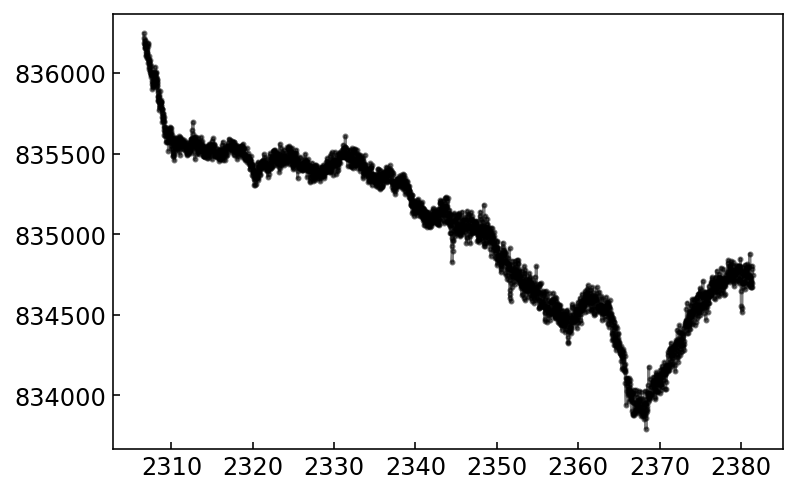

In [15]:
f = epic.flux
t = epic.time

badmask = epic.badmask
nanmask = epic.nanmask
outmask = epic.outmask
transitmask = epic.transitmask
fraw_err = epic.fraw_err
breakpoints = epic.breakpoints

# Get the cdpps
cdpp = epic.get_cdpp(f)
cdpp_arr = epic.get_cdpp_arr(f)


# Plot the good data points
t_c = epic.apply_mask(t)
f_c = epic.apply_mask(f)

pl.plot(t_c, f_c,
        marker='.', color='k', markersize=4, alpha=0.5)

## fit stellar variability

### analytically (linalg)

In [35]:
import numpy as np

def compute_w(vecs,y):
    #unpack n-dimensional vector
    X=np.c_[np.atleast_2d(vecs).T]
    try:
        w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, y))
    except:
        #if matrix is singular/ non-invertible
        w=np.linalg.lstsq(X,y, rcond=None)
    return w, X

In [93]:
order = 50
ti = t_c - t_c.mean()
v = [ti**i for i in range(order)]

#normalize flux
ff = f_c/np.median(f_c)
w,X = compute_w(v,ff)

#coefficients
w

array([ 1.00000978e+00, -2.74102539e-05, -1.46519814e-06, -6.99256552e-08,
        5.52477897e-08, -5.91021213e-09, -8.49741760e-10,  7.74973740e-11,
        5.22623277e-12, -3.95269784e-13, -1.52227151e-14,  1.03693906e-15,
        2.15680881e-17, -1.41468257e-18, -1.57202181e-20,  6.78835841e-22,
        1.89390890e-23,  5.32925401e-25, -3.91613356e-26, -4.94329661e-28,
        3.48008352e-29, -4.01730373e-31, -1.01435589e-32,  2.53894128e-34,
        9.53811820e-36,  3.85448993e-37, -5.14610279e-39, -2.98737605e-41,
       -1.59504284e-41, -3.89082081e-43,  5.94651286e-45, -9.79222679e-48,
        1.61927366e-47,  2.88525769e-49, -9.70539858e-51, -7.07774925e-53,
       -3.06755556e-54, -8.31457344e-56,  5.25514179e-57,  5.31712207e-59,
       -4.43936508e-60, -1.05228789e-62,  1.14429517e-63, -1.37407870e-65,
        2.02757455e-66,  1.92124515e-68, -1.63330936e-69, -8.93076881e-72,
        3.47318869e-73,  1.41724733e-75])

In [94]:
yhat = np.dot(X,w)
np.allclose(yhat,f_c, rtol=1e-1)

False

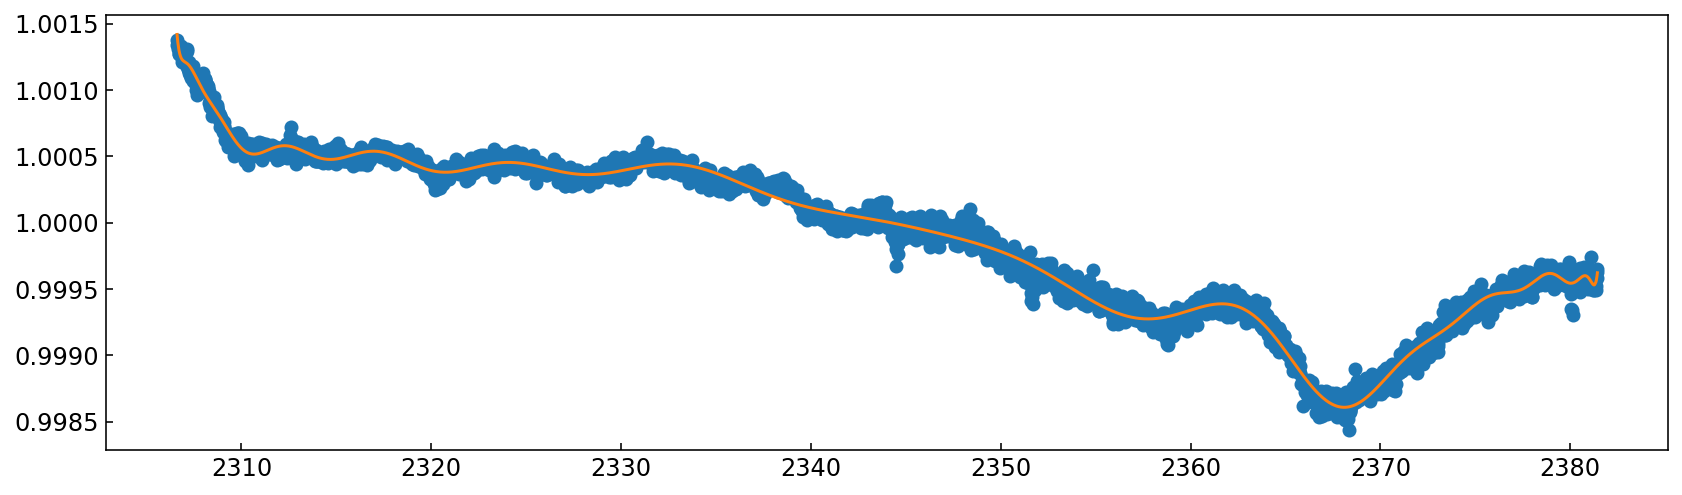

In [95]:
fig = pl.figure(figsize=(14,4))

pl.plot(t_c,ff,'o')
pl.plot(t_c,yhat,'-')

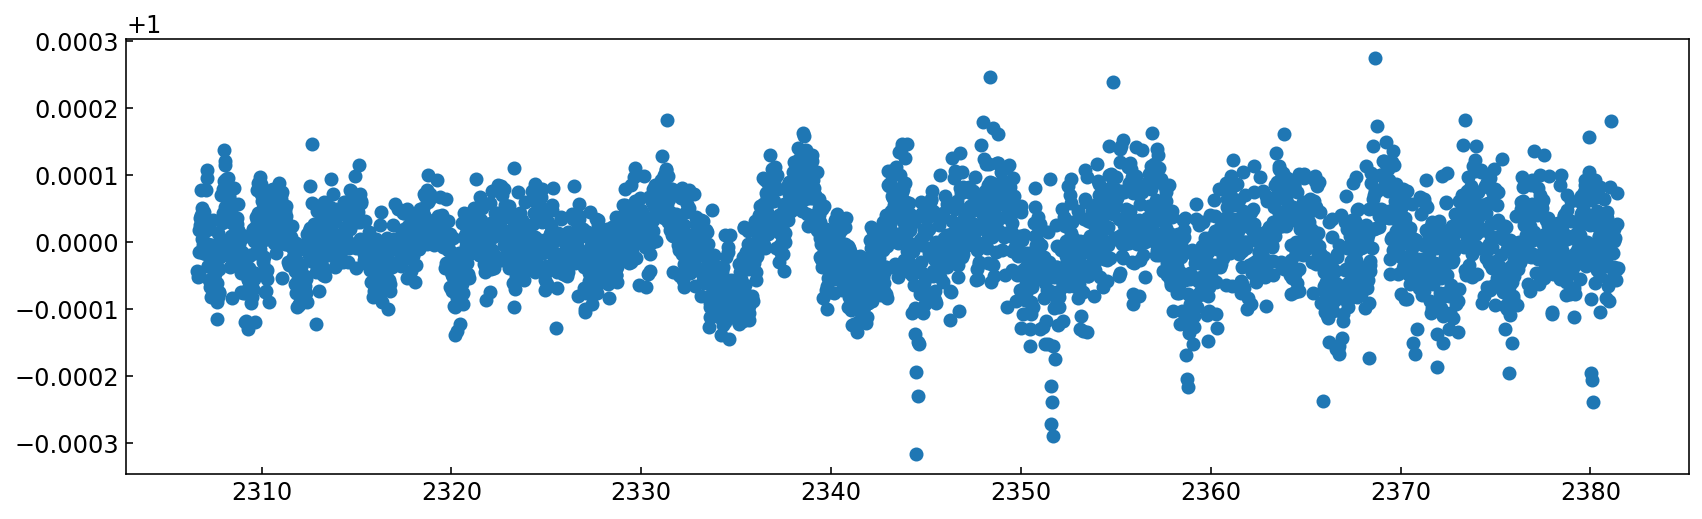

In [102]:
fig = pl.figure(figsize=(14,4))

f_d = ff/yhat
pl.plot(t_c,f_d,'o')
#pl.ylim(0.999,1.001)

* Period (d) 7.1125241
* Duration (hour) 2.79
* Depth (%) 0.11

### using median filter

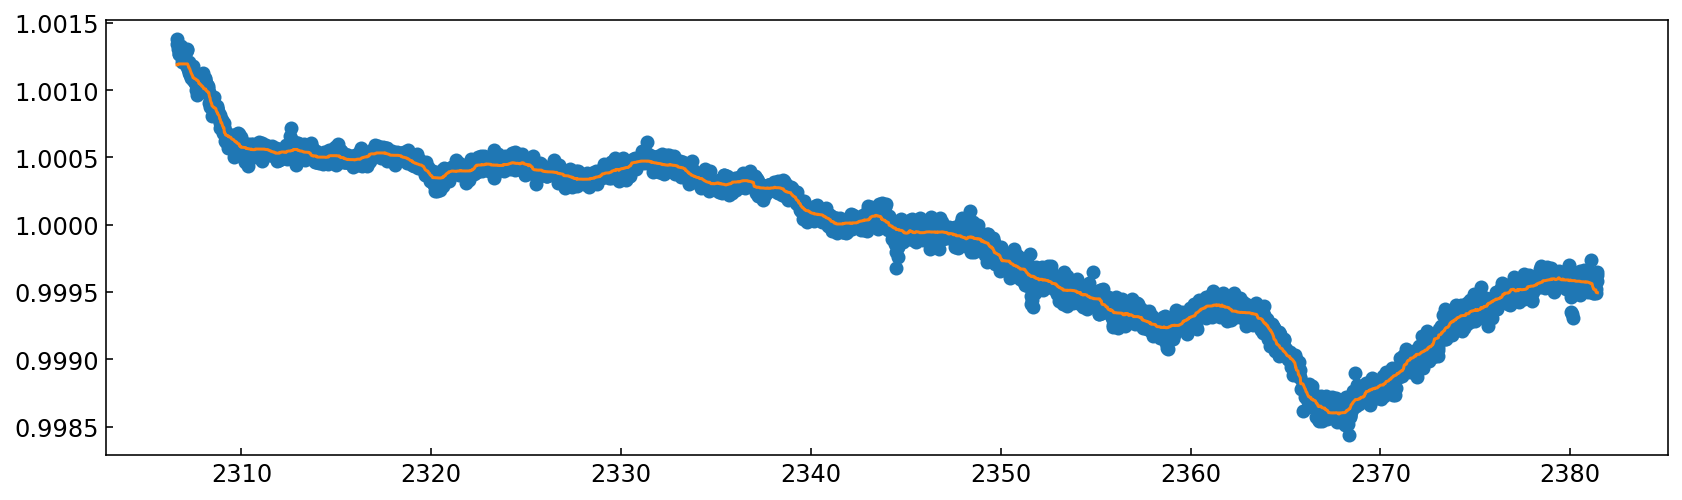

In [18]:
from scipy.signal import medfilt
import numpy as np

fig = pl.figure(figsize=(14,4))

ff = f_c/np.median(f_c)
yhat = medfilt(ff, kernel_size=51)

pl.plot(t_c,ff,'o')
pl.plot(t_c,yhat)

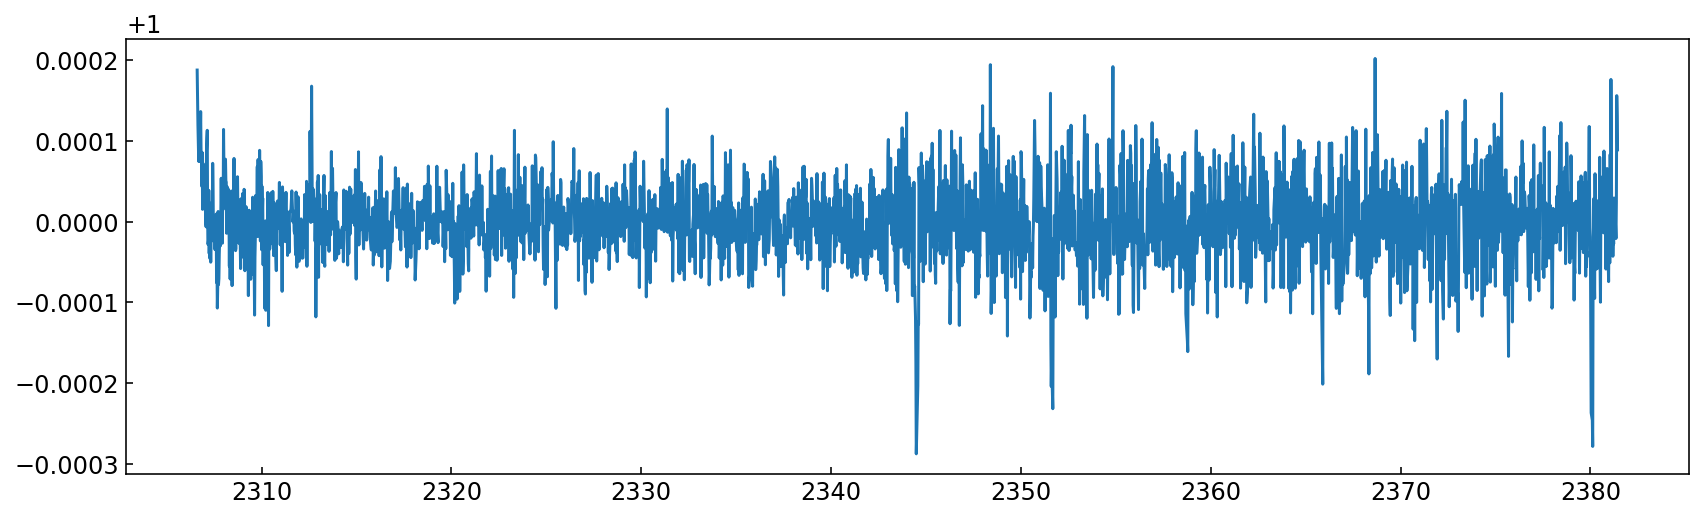

In [19]:
fig = pl.figure(figsize=(14,4))

f_d = ff/yhat
pl.plot(t_c,f_d,'-')

### using rbf

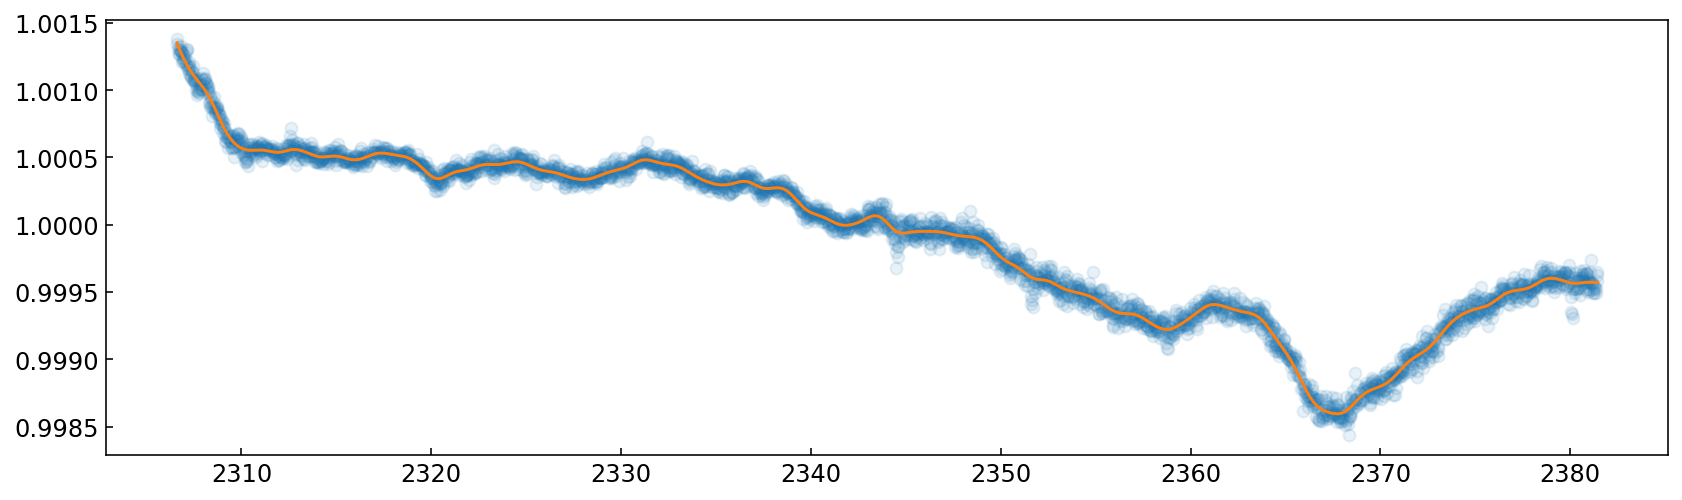

In [19]:
from scipy.interpolate import Rbf
import numpy as np

def rbf(x,y,func='quintic',smooth=0):
    rbfi = Rbf(x, y, function=func,smooth=smooth)  # radial basis function interpolator instance
    return rbfi
    
ff = f_c/np.median(f_c)
rbfi=rbf(t_c,ff,smooth=10)

yhat=rbfi(t_c)

fig = pl.figure(figsize=(14,4))
pl.plot(t_c,ff,'o',alpha=0.1)
pl.plot(t_c,yhat,'-')

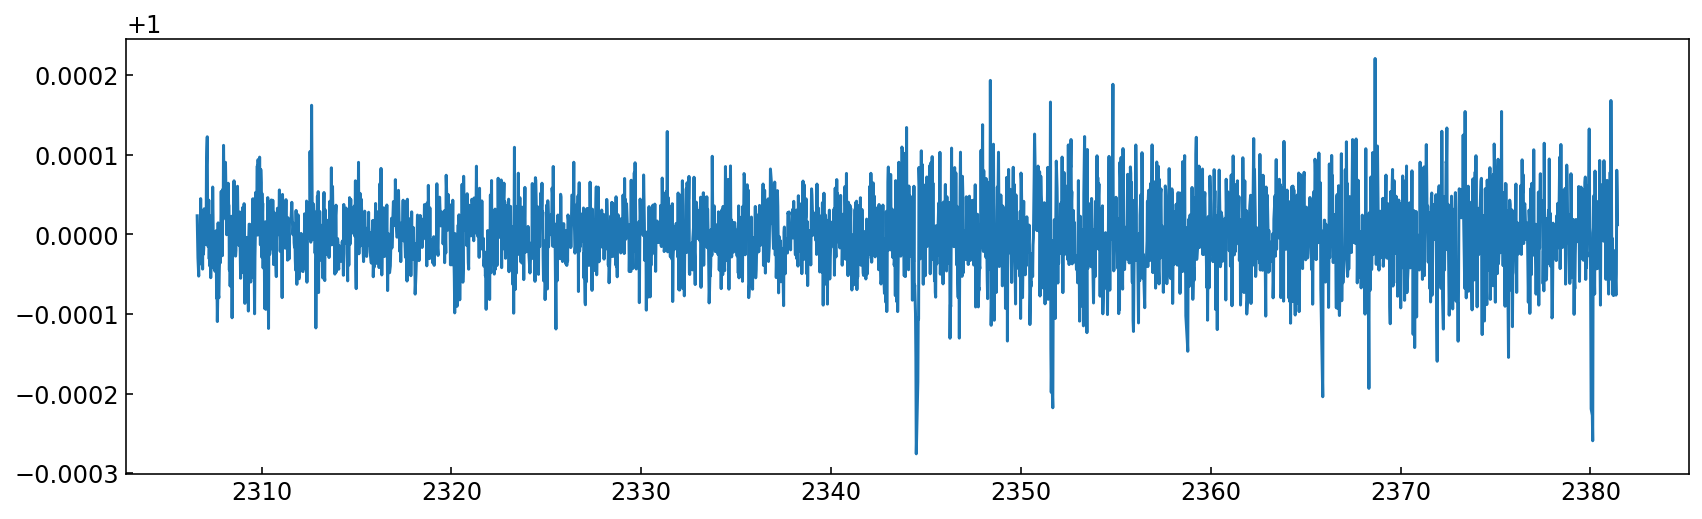

In [23]:
fig = pl.figure(figsize=(14,4))

f_d = ff/yhat
pl.plot(t_c,f_d,'-')

## fit high order variability

## find period

In [27]:
import gatspy
from gatspy.periodic import LombScargleFast
   
model = LombScargleFast().fit(t_c, f_d)
periods, power = model.periodogram_auto(nyquist_factor=100)

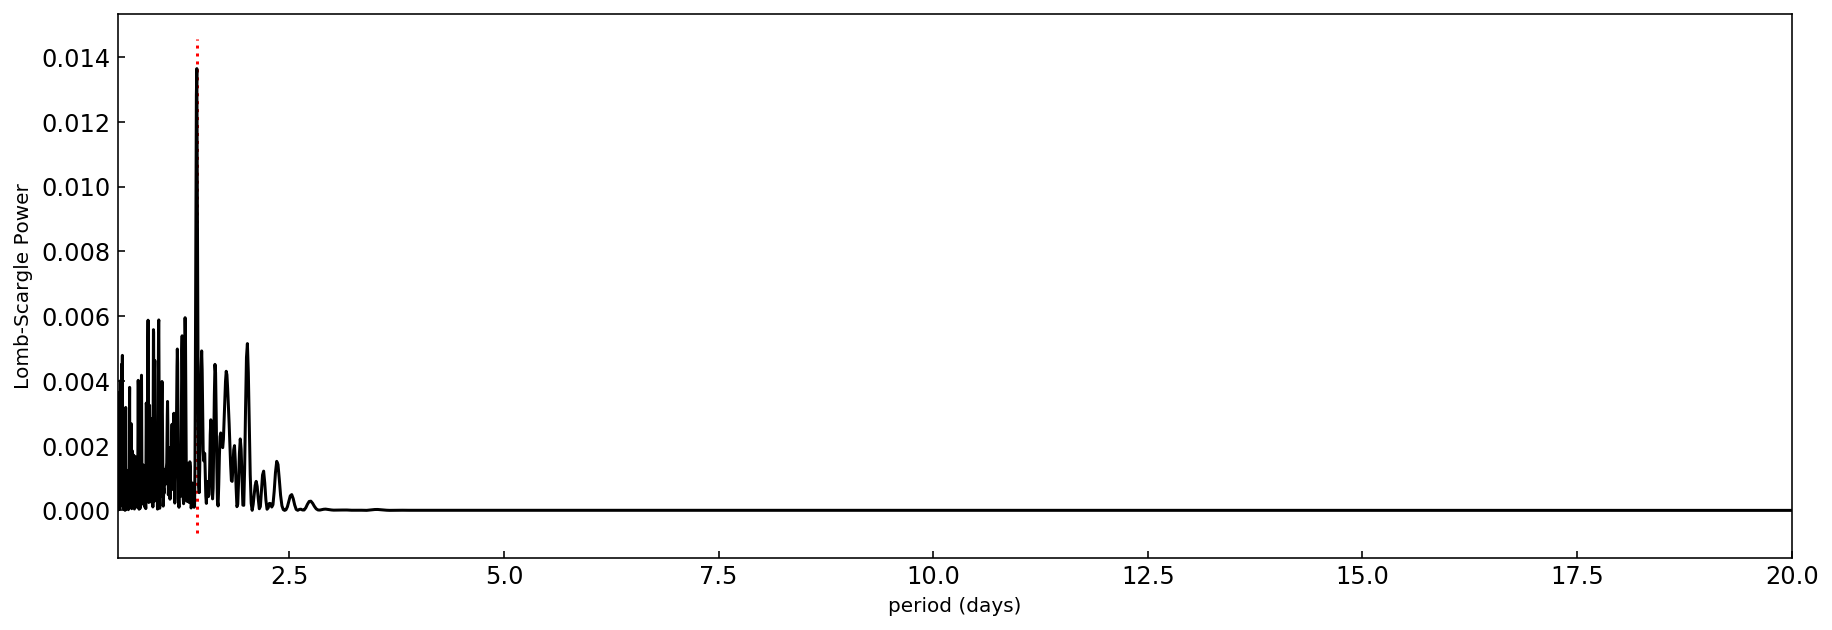

In [28]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 20),
        #ylim=(0, 0.01),
        xlabel='period (days)',
        ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [29]:
peak

1.422454306823485

According to KESPRINT, period is 7.1125241 d

## Phase-folding 

If there are transits/eclipses in a light curve, everest can use the GP prediction to whiten the timeseries and fold it on the period of the planet. If the time of first transit and period of an exoplanet/EB are known, plotting the folded transit/eclipse is easy. Just remember to mask the transit and re-compute the model beforehand:

In [44]:
peak = 7.1

phase = (t_c / peak) % 1

phase_fit = np.linspace(0, 1, 1000)
f_fit = model.predict(peak * phase_fit, period=peak)

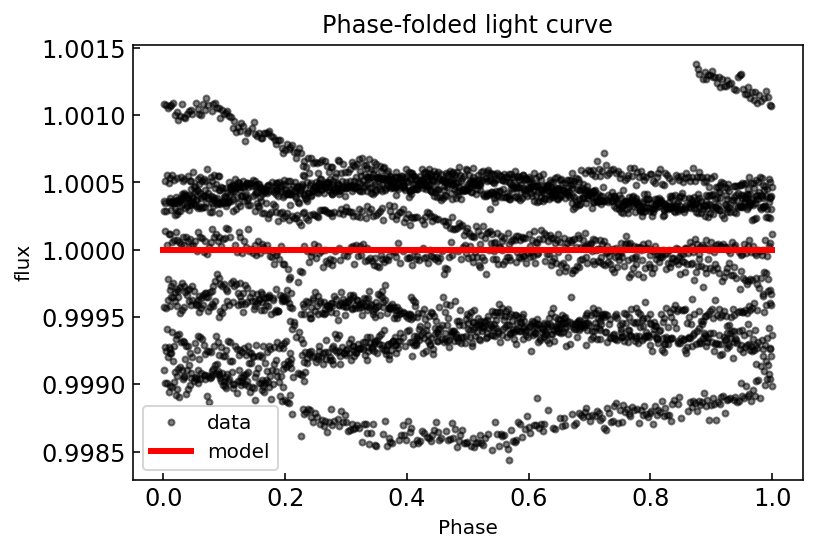

In [45]:
# Plot the phased data & model
fig, ax = pl.subplots()
ax.plot(phase, ff, '.k', alpha=0.5, label='data')
ax.plot(phase_fit, f_fit, '-r', lw=3, label='model')
ax.set(xlabel='Phase', 
       ylabel='flux',
      title='Phase-folded light curve');
ax.legend()

## estimate t0

In [ ]:
idx = (1216.75 < t) & (t < 1217.5)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [50]:
epic.plot_folded()

## model transit

In [31]:
def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3



def obj(theta, t, y, err, order=10):
    yhat = evaluate(theta, t, order=order)
    chi2 = ((y - yhat)/err)**2
    return np.sum(chi2)

In [32]:
order = 10
vecs = [ti**i for i in range(order)]

#normalize flux
ff = f_c/np.median(f_c)
w,X = compute_w(vecs,ff)

initial = np.copy(w)

e = epic.fraw_err
e_c = epic.apply_mask(t)

#normalize flux
args = (t_c, ff, e_c)

n_obj = lambda *args: -obj(*args)

import scipy.optimize as op

opt = op.minimize(n_obj, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

False
[ 4.30244035e+43  4.58298167e+38  1.15319568e+36 -8.39266360e+35
 -5.73652872e+34 -2.22240120e+33 -4.74622359e+31 -7.83873586e+30
  1.31848562e+26 -1.71891924e+26]


In [137]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    #prior
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf
    #loglike
    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [ ]:
p = peak
t14 = 0.15
k = np.sqrt(1-0.993)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1
initial = k,t0,p,a,i,u1,u2,sig,0,0,0,0
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

# Appendix